In [1]:
import os.path
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import pickle
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
import pylab as pl
from moviepy.editor import VideoFileClip

%matplotlib inline

In [2]:
hogcolorspace = 'YCrCb'
spatialbinsize = (32,32)
histbinsize = 16
hogc = 'ALL' #0,1,2,ALL
orient = 11
pixpercell = 16
cellperblock =  2
ystart = 400
ystop = 650
scalestart = 1.0
scalestop = 3.5
conv = 'RGB2YCrCb'

Loaded car list with 8792 images.
Loaded non-car list with 8968 images.
Image shape: (64, 64, 3)


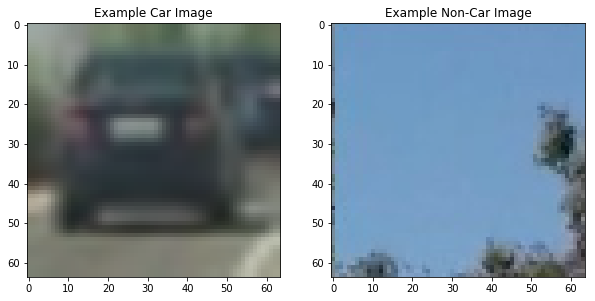

In [3]:
carlist = glob.glob('/Users/Admin/Desktop/vehicles/**/*.png', recursive = True)
notcarlist = glob.glob('/Users/Admin/Desktop/non-vehicles/**/*.png', recursive = True)

print("Loaded car list with", len(carlist), "images.")
print("Loaded non-car list with", len(notcarlist), "images.")
testim = mpimg.imread(carlist[0])
testim2 = mpimg.imread(notcarlist[0])
print("Image shape:", testim.shape)

fig = plt.figure(figsize = (10,20))
plt.subplot(1,2,1)
plt.imshow(testim)
plt.title('Example Car Image')

plt.subplot(1,2,2)
plt.imshow(testim2)
plt.title('Example Non-Car Image')


#TODO: 
# -- DELETE THESE
# -- PRINT IMAGES FOR EACH STEP (GROSS)
# -- ADD OWN COMMENTS TO CODE




###PT 28: GOOD COLOR CONFIG LOOK
###PT 29: COMBINE BOTH HOG AND COLOR
###PT 27: AUTO PARAM TUNE


In [4]:
def spatial_bin(img, size=(32, 32)):
    
    #Create a resized feature vector
    features = cv2.resize(img, size).ravel() 
    
    return features

################################################################################################################################

def color_hist(img, bins=32, binrange=(0, 256)):
    
    # Create separate histograms for each color channel
    channel1 = np.histogram(img[:,:,0], bins=bins, range=binrange)
    channel2 = np.histogram(img[:,:,1], bins=bins, range=binrange)
    channel3 = np.histogram(img[:,:,2], bins=bins, range=binrange)
    
    # Concatenate into single feature vector
    features = np.concatenate((channel1[0], channel2[0], channel3[0]))
    
    return features

################################################################################################################################

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), hog_channel = 0, orient = 9,
                    pix_per_cell = 8, cell_per_block = 2, vis = False, feature_vec = True):
    # Create a feature list
    features = []
    
    # Loop through and read in images
    for i in imgs:
        
        # Read in images
        image = mpimg.imread(i)
        
        # Change color space or leave RGB
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image) 
            
        # Apply spatial_bin function
        spatial_features = spatial_bin(feature_image, size=spatial_size)
        
        # Apply color_hist function
        hist_features = color_hist(feature_image, bins=hist_bins, binrange=hist_range)
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)) 
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                           pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        
        # Append concatenated features to feature list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))

    return features

################################################################################################################################

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    # Return both features and output image if desired
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
################################################################################################################################    
    
# def slide_windowsearch(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
#     # If no set starting and stopping point, use whole image
#     if x_start_stop[0] == None:
#         x_start_stop[0] = 0
#     if x_start_stop[1] == None:
#         x_start_stop[1] = img.shape[1]
#     if y_start_stop[0] == None:
#         y_start_stop[0] = 0
#     if y_start_stop[1] == None:
#         y_start_stop[1] = img.shape[0]
        
#     # Compute the region to be searched within the image
#     xspan = x_start_stop[1] - x_start_stop[0]
#     yspan = y_start_stop[1] - y_start_stop[0]
    
#     # Compute pixels per window
#     nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
#     ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
#     # Compute the number of windows for x/y
#     nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
#     ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
#     nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
#     ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
#     window_list = []
    
#     # Loop through to find window pos
#     for ys in range(ny_windows):
#         for xs in range(nx_windows):
            
#             # Calculate window position
#             startx = xs*nx_pix_per_step + x_start_stop[0]
#             endx = startx + xy_window[0]
#             starty = ys*ny_pix_per_step + y_start_stop[0]
#             endy = starty + xy_window[1]
            
#             # Append to window list
#             window_list.append(((startx, starty), (endx, endy)))
            
#     return window_list

################################################################################################################################

# def get_windows(img, windows, clf, scaler, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
#                     pix_per_cell=8, cell_per_block=2, hog_channel=0):

#     on_windows = []
    
#     for window in windows:
#         # Iterate through windows and capture desired frame
#         test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
#         # Extract features from captured frame to be classified
#         features = single_features(test_img, cspace=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel)
        
#         # Scale features 
#         test_features = scaler.transform(np.array(features).reshape(1, -1))
        
#         # Predict using your classifier
#         prediction = clf.predict(test_features)
        
#         # If classifier prediction is car then store to window list
#         if prediction == 1:
#             on_windows.append(window)
    
#     return on_windows

################################################################################################################################

# def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
#     # Copy image
#     imcopy = np.copy(img)
    
#     for bbox in bboxes:
#         # Draw a box for each coordinate in bboxes
#         cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
#     return imcopy

################################################################################################################################

# def single_features(img, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), hog_channel = 0, orient = 9,
#                     pix_per_cell = 8, cell_per_block = 2, vis = False, feature_vec = True):
    
#     # Create a feature list
#     features = []
#     image = img

#     # Change color space or leave RGB
#     if cspace == 'HSV':
#         feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     elif cspace == 'HLS':
#          feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#     elif cspace == 'YUV':
#          feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#     else:
#         feature_image = np.copy(image) 
            
#     # Apply spatial_bin function
#     spatial_features = spatial_bin(feature_image, size=spatial_size)
        
#     # Apply color_hist function
#     hist_features = color_hist(feature_image, bins=hist_bins, binrange=hist_range)
        
#     if hog_channel == 'ALL':
#         hog_features = []
#         for channel in range(feature_image.shape[2]):
#             hog_features.extend(get_hog_features(feature_image[:,:,channel], 
#                                 orient, pix_per_cell, cell_per_block, 
#                                 vis=False, feature_vec=True)) 
#     else:
#         hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        
#     # Append concatenated features to feature list
#     features.append(np.concatenate((spatial_features, hist_features, hog_features)))   
    
#     return features

################################################################################################################################

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, conv):
    
    bboxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=conv)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = spatial_bin(subimg, size=spatial_size)
            hist_features = color_hist(subimg, bins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                box = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                bboxes.append(box)
                
    return draw_img, bboxes

################################################################################################################################

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

################################################################################################################################   
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
################################################################################################################################    
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

##############################################################################################################################

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

##############################################################################################################################

def multi_scale(image, ystart, ystop, scalestart, scalestop, clf, Xscaler, orient, pixpercell, cellperblock, 
                     spatialbinsize, histbinsize, conv):
    
    increments = pl.frange(scalestart,scalestop,0.5)
    bounds = []
    
    for i in increments:
        img,bboxes = find_cars(image, ystart, ystop, i, clf, Xscaler, orient, pixpercell, cellperblock, spatialbinsize, 
                    histbinsize, conv)
        bounds.extend(bboxes)
    return bounds

##############################################################################################################################

def videopipeline(img):
    
    hogcolorspace = 'YCrCb'
    spatialbinsize = (32,32)
    histbinsize = 16
    hogc = 'ALL' #0,1,2,ALL
    orient = 11
    pixpercell = 16
    cellperblock =  2
    ystart = 400
    ystop = 650
    scalestart = 1.0
    scalestop = 3.5
    conv = 'RGB2YCrCb'
    
    multboxes = multi_scale(img, ystart, ystop, scalestart, scalestop, clf, Xscaler, orient, pixpercell, cellperblock, 
                    spatialbinsize, histbinsize, conv)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    heat = add_heat(heat,multboxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

##############################################################################################################################

print("Defining Functions: Done")

Defining Functions: Done


In [5]:
# Extract car and noncar features with extract_features or load previously saved


# extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), hog_channel = 0, orient = 9,
#                    pix_per_cell = 8, cell_per_block = 2, vis = False, feature_vec = True):

print("Extracting Features...")
    
carfeatures = extract_features(carlist, cspace = hogcolorspace, spatial_size = spatialbinsize,
                               hist_bins = histbinsize, hist_range = (0, 256), hog_channel = hogc, orient = orient, 
                               pix_per_cell = pixpercell, cell_per_block = cellperblock)

notcarfeatures = extract_features(notcarlist, cspace = hogcolorspace, spatial_size = spatialbinsize,
                               hist_bins = histbinsize, hist_range = (0, 256), hog_channel = hogc, orient = orient, 
                               pix_per_cell = pixpercell, cell_per_block = cellperblock)
print("Done.")

Extracting Features...
Done.


In [6]:
#Normalize features:

# Stack feature vectors
X = np.vstack((carfeatures, notcarfeatures)).astype(np.float64)  

# Fit scaler
Xscaler = StandardScaler().fit(X)

# Apply scaler
scaledX = Xscaler.transform(X)

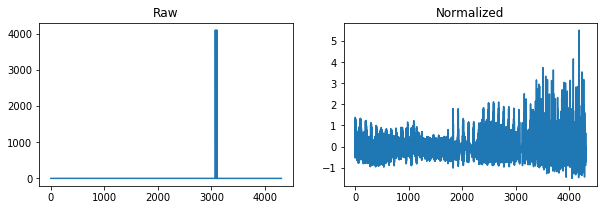

In [7]:
# Plot figures to show raw and normalized features

fig2 = plt.figure(figsize = (10,3))

plt.subplot(1,2,1)
plt.plot(X[1])
plt.title('Raw')

plt.subplot(1,2,2)
plt.plot(scaledX[1])
plt.title('Normalized')

In [8]:
# Create an array of feature labels. Car features being a 1 and non-car features being a 0.

y = np.hstack((np.ones(len(carfeatures)), np.zeros(len(notcarfeatures))))

In [9]:
# Split data into training and test sets 

rand = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaledX, y, test_size=0.2, random_state=rand)

print("Feature vector length:", len(X_train[0]))

Feature vector length: 4308


In [10]:
# Create a classifier:


print("Training...")
    
# Using linear SVC
clf = LinearSVC()

# Measure training time
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print("Trained SVC in: ", round(t2-t, 2), "seconds")

# Print accuracy
print('Accuracy  = ', round(clf.score(X_test, y_test), 4) * 100, "%")
    
# Pickle classifier
pickle.dump(clf,open("savedclf.p", "wb"))
    
print("Saved classifier")

Training...
Trained SVC in:  9.81 seconds
Accuracy  =  98.56 %
Saved classifier


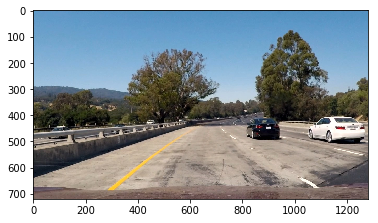

In [11]:
image = mpimg.imread('test_images/test1.jpg')
plt.imshow(image)

In [12]:
scale = 1.5

drawimg,bboxes = find_cars(image, ystart, ystop, scale, clf, Xscaler, orient, pixpercell, cellperblock, spatialbinsize, 
                    histbinsize, conv = conv)

multboxes = multi_scale(image, ystart, ystop, scalestart, scalestop, clf, Xscaler, orient, pixpercell, cellperblock, 
                        spatialbinsize, histbinsize, conv)


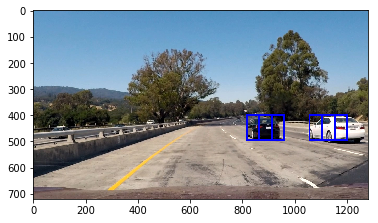

In [13]:
plt.imshow(drawimg)

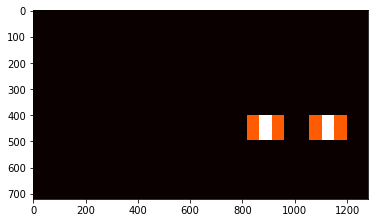

2 probable cars


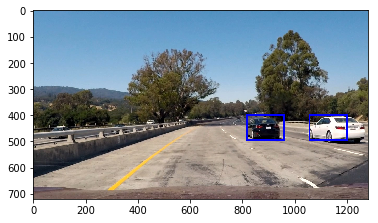

In [14]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)


heat = add_heat(heat,bboxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0.5)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

plt.imshow(heatmap, cmap = 'hot')
plt.show()

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

print(labels[1], 'probable cars')
plt.imshow(draw_img)

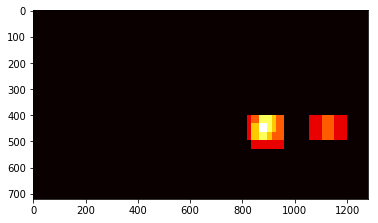

2 probable cars


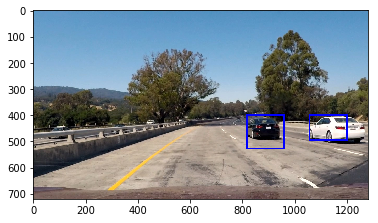

In [15]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,multboxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying
heatmap = np.clip(heat, 0, 255)

plt.imshow(heatmap, cmap = 'hot')
plt.show()

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

print(labels[1], 'probable cars')
plt.imshow(draw_img)

In [ ]:
output = 'output_images/project_video_output12.mp4'

# .save_frame("frame.png", t=22.5)
# .subclip(23,25)
# .subclip(38,42)

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(videopipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()